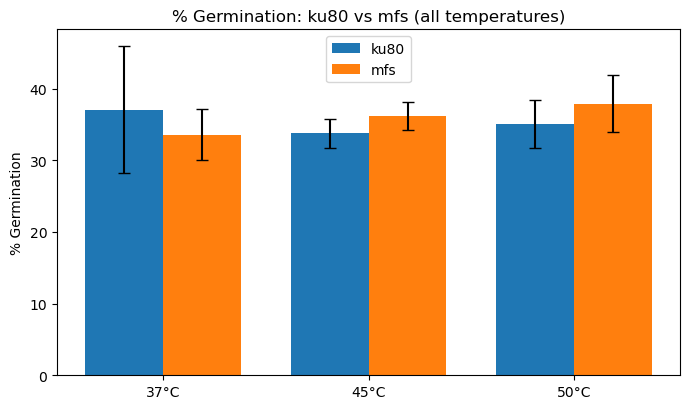

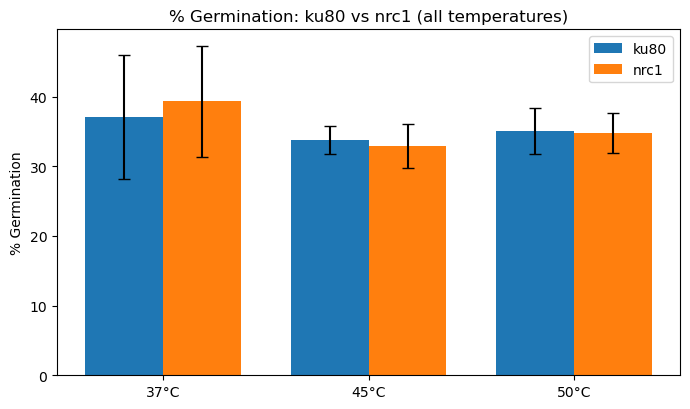

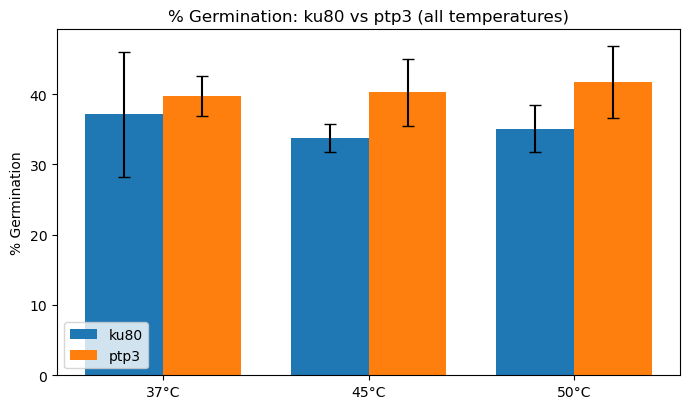

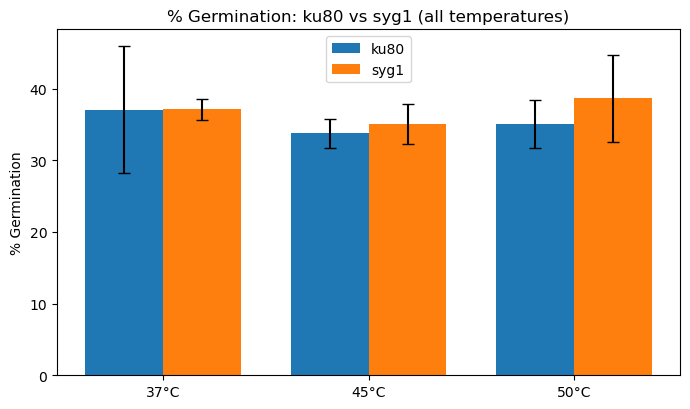

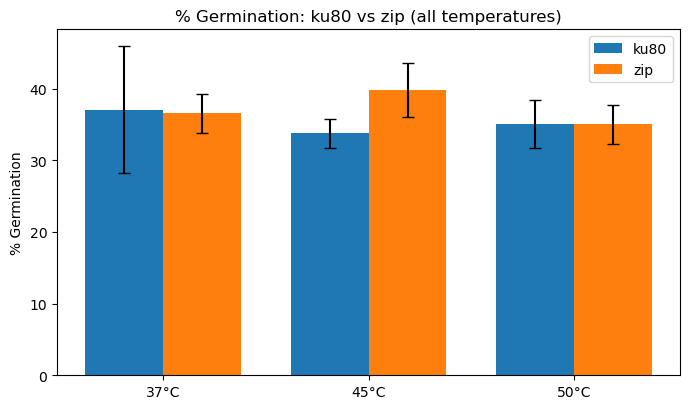

In [4]:
# === Ku80 vs Each Strain: grouped bars with error bars =======================
# Expects columns: file, temperature, percent_germinated
# One figure per strain (ku80 vs <strain>), grouped by temps (37/45/50 °C).
# Error bars: set ERROR_BARS to "sd" (std dev) or "sem" (standard error), or None.

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------- CONFIG --------------------------------------------
CSV_PATH = Path("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/germination_measurements_all_temp_perfile.csv")
KU80_LABEL = "ku80"               # case-insensitive match to reference strain
TEMPS = [37, 45, 50]              # order on x-axis
GERM_COL = "percent_germinated"   # % germination column
ERROR_BARS = "sd"                 # "sd", "sem", or None
SAVE = False                      # True to save PNGs
OUT_DIR = Path("/mnt/data/germination_grouped_plots")
# -----------------------------------------------------------------------------

# Load & standardize
df = pd.read_csv(CSV_PATH).rename(columns={"file": "Strain", "temperature": "Temperature"})
df["Strain"] = df["Strain"].astype(str).str.strip()
df["strain_lower"] = df["Strain"].str.lower().str.strip()
df["Temperature"] = pd.to_numeric(df["Temperature"], errors="coerce")

# Aggregate with explicit names (avoids KeyError on 'mean')
base = (
    df.dropna(subset=["Temperature"])
      .groupby(["strain_lower", "Temperature"])[GERM_COL]
      .agg(mean="mean", count="count", sd=lambda x: x.std(ddof=1))
      .reset_index()
)

# Add SEM if needed
if ERROR_BARS == "sem":
    base["err"] = base["sd"] / np.sqrt(base["count"].replace(0, np.nan))
elif ERROR_BARS == "sd":
    base["err"] = base["sd"]
else:
    base["err"] = np.nan

# Which strains (exclude ku80)
other_strains = [s for s in sorted(df["strain_lower"].unique()) if s != KU80_LABEL.lower()]

def grouped_bars_for_strain(strain_other: str):
    # Pull ku80 rows and other rows once for speed
    kdata = base[base["strain_lower"] == KU80_LABEL.lower()]
    odata = base[base["strain_lower"] == strain_other.lower()]
    # Prepare vectors in the desired temp order
    ku_means = []
    ku_errs  = []
    other_means = []
    other_errs  = []
    for t in TEMPS:
        r_k = kdata[kdata["Temperature"] == t]
        r_o = odata[odata["Temperature"] == t]
        ku_means.append(r_k["mean"].iloc[0] if len(r_k) else np.nan)
        ku_errs.append(r_k["err"].iloc[0] if (ERROR_BARS and len(r_k)) else np.nan)
        other_means.append(r_o["mean"].iloc[0] if len(r_o) else np.nan)
        other_errs.append(r_o["err"].iloc[0] if (ERROR_BARS and len(r_o)) else np.nan)

    x = np.arange(len(TEMPS))
    width = 0.38

    fig = plt.figure(figsize=(7, 4.2))
    plt.bar(x - width/2, ku_means, width,
            yerr=ku_errs if ERROR_BARS else None, capsize=4 if ERROR_BARS else 0,
            label="ku80")
    pretty_other = df.loc[df["strain_lower"] == strain_other, "Strain"].iloc[0] \
                   if (df["strain_lower"] == strain_other).any() else strain_other
    plt.bar(x + width/2, other_means, width,
            yerr=other_errs if ERROR_BARS else None, capsize=4 if ERROR_BARS else 0,
            label=pretty_other)

    plt.xticks(x, [f"{int(t)}°C" for t in TEMPS])
    plt.ylabel("% Germination")
    plt.title(f"% Germination: ku80 vs {pretty_other} (all temperatures)")
    plt.legend()
    plt.tight_layout()
    if SAVE:
        OUT_DIR.mkdir(parents=True, exist_ok=True)
        safename = f"ku80_vs_{pretty_other}_grouped.png".replace(" ", "_")
        plt.savefig(OUT_DIR / safename, dpi=150, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

# Generate exactly one figure per non-ku80 strain
for s in other_strains:
    grouped_bars_for_strain(s)


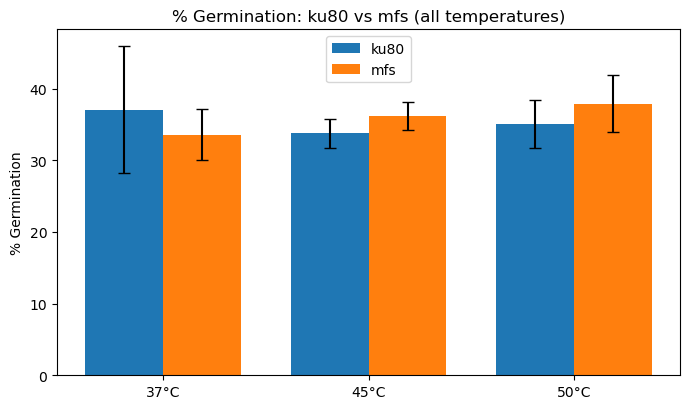

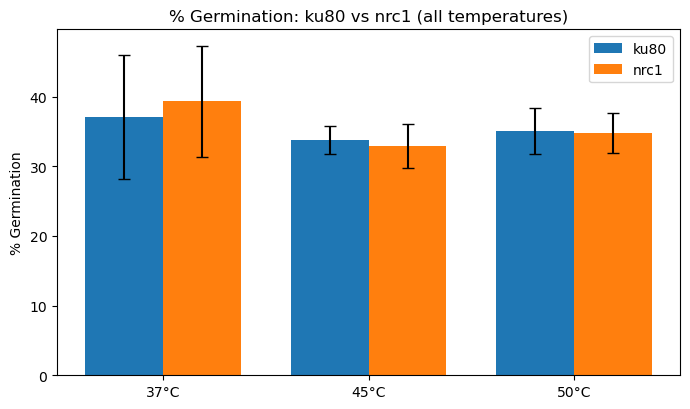

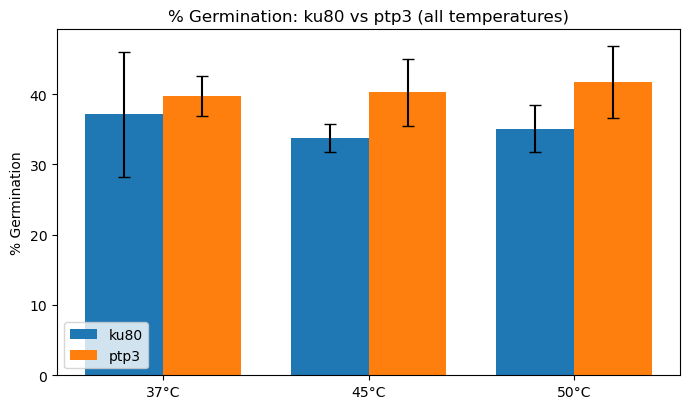

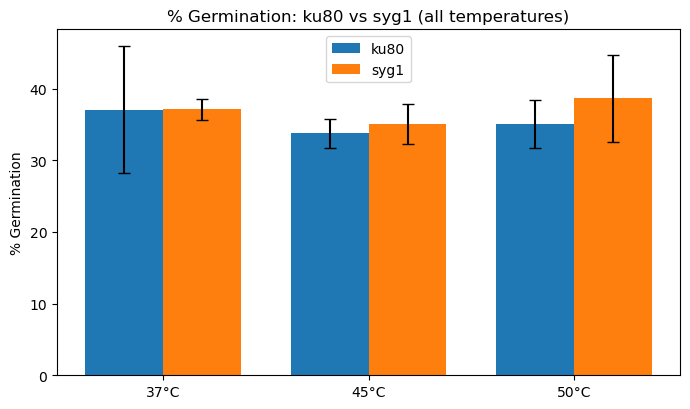

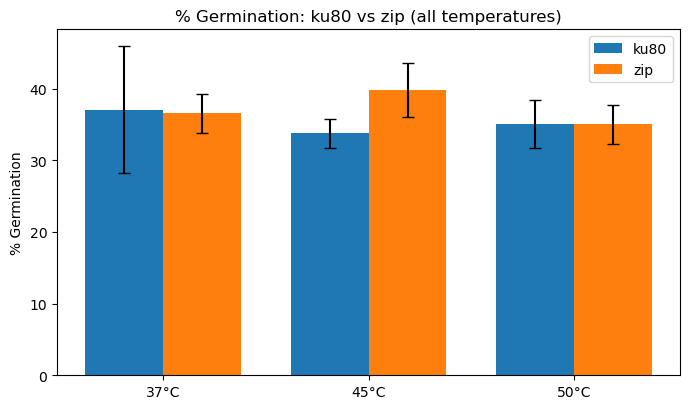

In [5]:
# === Ku80 vs Each Strain: grouped bars + 2-way ANOVA + Tukey-based sig ======
# Input columns: file, temperature, percent_germinated
# For each strain X != ku80, we:
#   1) Run two-way ANOVA on subset (Strain in {ku80, X}) with factors Strain, Temperature.
#   2) Do Tukey HSD across (Strain x Temperature) groups to test ku80 vs X at each temperature.
#   3) Plot grouped bars (ku80 vs X) over 37/45/50°C, with error bars, and annotate only when significant.

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# ------------------------- CONFIG --------------------------------------------
CSV_PATH = Path("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/germination_measurements_all_temp_perfile.csv")
KU80_LABEL = "ku80"               # case-insensitive
TEMPS = [37, 45, 50]              # order on x-axis
GERM_COL = "percent_germinated"   # metric to analyze/plot
ERROR_BARS = "sd"                 # one of: "sd", "sem", None
ALPHA = 0.05                      # significance threshold for Tukey HSD
SAVE = False                      # True => save PNGs to OUT_DIR
OUT_DIR = Path("/mnt/data/germination_grouped_plots")
# -----------------------------------------------------------------------------

# Load & standardize
df = pd.read_csv(CSV_PATH).rename(columns={"file": "Strain", "temperature": "Temperature"})
df["Strain"] = df["Strain"].astype(str).str.strip()
df["strain_lower"] = df["Strain"].str.lower().str.strip()
df["Temperature"] = pd.to_numeric(df["Temperature"], errors="coerce")

# Basic summary for plotting errors
def summarize(df_subset):
    """Return mean, n, sd, sem for df_subset[GERM_COL]."""
    vals = df_subset[GERM_COL].dropna()
    mean = vals.mean()
    n = vals.count()
    sd = vals.std(ddof=1) if n > 1 else 0.0
    sem = (sd / np.sqrt(n)) if n > 0 else np.nan
    return mean, n, sd, sem

def get_error(sd, sem):
    if ERROR_BARS == "sd":
        return sd
    if ERROR_BARS == "sem":
        return sem
    return None

def stars_from_p(p):
    if p is None or np.isnan(p):
        return None
    if p < 0.0001: return "****"
    if p < 0.001:  return "***"
    if p < 0.01:   return "**"
    if p < 0.05:   return "*"
    return None

def anova_and_tukey_for_pair(df_pair):
    """
    Two-way ANOVA on df_pair (Strain in {ku80, other}), factors: C(Strain)*C(Temperature).
    Then Tukey HSD on the combined factor 'Grp = Strain_Temp', and extract ku80 vs other p-values per temp.
    Returns:
      - anova_table (DataFrame)
      - dict: temp -> pvalue (ku80 vs other at that temp) or None if either missing.
    """
    # Ensure categorical types for clean modeling
    dmod = df_pair.copy()
    dmod["Strain"] = dmod["Strain"].astype(str)
    dmod["Temperature"] = dmod["Temperature"].astype(int)

    # Two-way ANOVA
    model = ols(f"{GERM_COL} ~ C(Strain) * C(Temperature)", data=dmod).fit()
    anova_tbl = sm.stats.anova_lm(model, typ=2)

    # Tukey across Strain x Temperature groups
    dmod["Grp"] = dmod["Strain"].astype(str) + "_" + dmod["Temperature"].astype(str)
    tuk = pairwise_tukeyhsd(endog=dmod[GERM_COL], groups=dmod["Grp"], alpha=ALPHA)

    # Build a p-value lookup (groupA, groupB) -> p-adj
    # Note: tukey result stores arrays; we reconstruct pairs.
    res = pd.DataFrame({
        "group1": tuk.groupsunique[tuk._multicomp.pairindices[0]],
        "group2": tuk.groupsunique[tuk._multicomp.pairindices[1]],
        "meandiff": tuk.meandiffs,
        "p_adj": tuk.pvalues,
        "reject": tuk.reject
    })

    # Extract per-temp p-values for ku80 vs other (exact labels)
    temps = sorted(dmod["Temperature"].unique())
    comp_p = {}
    other_label = [s for s in dmod["Strain"].unique() if s.lower() != KU80_LABEL.lower()]
    other_label = other_label[0] if other_label else None

    for t in temps:
        if other_label is None:
            comp_p[t] = None
            continue
        g_ku = f"{dmod.loc[dmod['Strain'].str.lower()==KU80_LABEL.lower(), 'Strain'].iloc[0]}_{t}"
        g_ot = f"{other_label}_{t}"
        # Try both orders
        mask = ((res["group1"] == g_ku) & (res["group2"] == g_ot)) | ((res["group1"] == g_ot) & (res["group2"] == g_ku))
        if mask.any():
            comp_p[t] = float(res.loc[mask, "p_adj"].iloc[0])
        else:
            comp_p[t] = None  # no comparison available (missing data)
    return anova_tbl, comp_p

def plot_pair_grouped_with_sig(df_all, other_strain_lower):
    sub = df_all[df_all["strain_lower"].isin([KU80_LABEL.lower(), other_strain_lower])].copy()
    if sub.empty:
        return

    # Run ANOVA + Tukey to get per-temp p-values
    anova_tbl, pvals_by_temp = anova_and_tukey_for_pair(sub)

    # Build plotting vectors (means and errors for ku80 & other at each temperature)
    other_pretty = sub.loc[sub["strain_lower"] == other_strain_lower, "Strain"].iloc[0]
    ku_means, ku_errs, other_means, other_errs = [], [], [], []
    ymax_est = 0.0

    for t in TEMPS:
        ku_t = sub[(sub["strain_lower"] == KU80_LABEL.lower()) & (sub["Temperature"] == t)]
        ot_t = sub[(sub["strain_lower"] == other_strain_lower) & (sub["Temperature"] == t)]

        ku_mean, ku_n, ku_sd, ku_sem = summarize(ku_t)
        ot_mean, ot_n, ot_sd, ot_sem = summarize(ot_t)

        ku_means.append(ku_mean if ku_n > 0 else np.nan)
        other_means.append(ot_mean if ot_n > 0 else np.nan)

        ku_errs.append(get_error(ku_sd, ku_sem))
        other_errs.append(get_error(ot_sd, ot_sem))

        # Track for y-limit placement (include error bars if drawn)
        yk = (ku_mean or 0) + (ku_errs[-1] or 0)
        yo = (ot_mean or 0) + (other_errs[-1] or 0)
        ymax_est = max(ymax_est, yk, yo)

    # Plot
    x = np.arange(len(TEMPS))
    width = 0.38
    fig = plt.figure(figsize=(7, 4.2))
    b1 = plt.bar(x - width/2, ku_means, width,
                 yerr=ku_errs if ERROR_BARS else None,
                 capsize=4 if ERROR_BARS else 0,
                 label="ku80")
    b2 = plt.bar(x + width/2, other_means, width,
                 yerr=other_errs if ERROR_BARS else None,
                 capsize=4 if ERROR_BARS else 0,
                 label=other_pretty)

    plt.xticks(x, [f"{int(t)}°C" for t in TEMPS])
    plt.ylabel("% Germination")
    plt.title(f"% Germination: ku80 vs {other_pretty} (all temperatures)")
    plt.legend()

    # Add significance markers (only where Tukey says significant)
    # Simple caret (^) above the higher bar at that group; change to stars if you prefer
    # Here we draw stars centered between the two bars for each temperature.
    y_offset = 0.03 * (ymax_est if ymax_est > 0 else 1.0) + 0.5
    for i, t in enumerate(TEMPS):
        p = pvals_by_temp.get(t, None)
        star = stars_from_p(p)
        if star:
            # y-position a bit above both bars at this temp
            y_i = max(
                (ku_means[i] if not np.isnan(ku_means[i]) else 0) + (ku_errs[i] if ERROR_BARS and ku_errs[i] is not None else 0),
                (other_means[i] if not np.isnan(other_means[i]) else 0) + (other_errs[i] if ERROR_BARS and other_errs[i] is not None else 0)
            ) + y_offset
            # center annotation between bars
            x_center = (x[i] - width/2 + x[i] + width/2) / 2
            plt.text(x_center, y_i, star, ha="center", va="bottom", fontsize=12)

    plt.tight_layout()

    if SAVE:
        OUT_DIR.mkdir(parents=True, exist_ok=True)
        safename = f"ku80_vs_{other_pretty}_grouped_anova.png".replace(" ", "_")
        plt.savefig(OUT_DIR / safename, dpi=150, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

# ---------- Run for each non-ku80 strain -------------------------------------
other_strains = [s for s in sorted(df["strain_lower"].unique()) if s != KU80_LABEL.lower()]
for s in other_strains:
    plot_pair_grouped_with_sig(df, s)



Two-way ANOVA: ku80 vs mfs
                              sum_sq    df         F    PR(>F)
C(Strain)                   0.422568   1.0  0.017830  0.895549
C(Temperature)              6.290927   2.0  0.132724  0.876724
C(Strain):C(Temperature)   46.635179   2.0  0.983897  0.396729
Residual                  355.488350  15.0       NaN       NaN


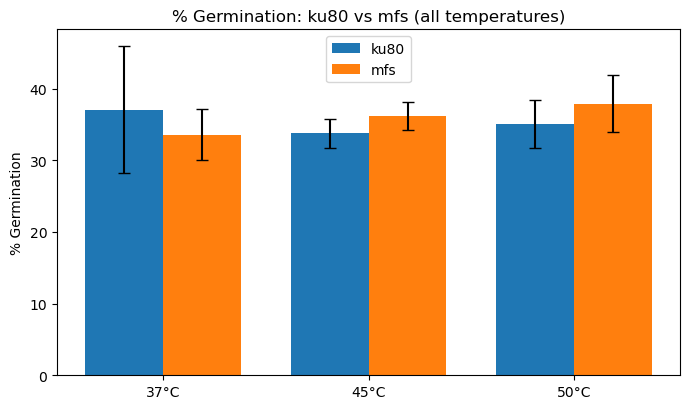


Two-way ANOVA: ku80 vs nrc1
                              sum_sq    df         F    PR(>F)
C(Strain)                   2.069928   1.0  0.055642  0.816339
C(Temperature)            105.151571   2.0  1.413305  0.270523
C(Strain):C(Temperature)   11.094228   2.0  0.149114  0.862586
Residual                  632.410323  17.0       NaN       NaN


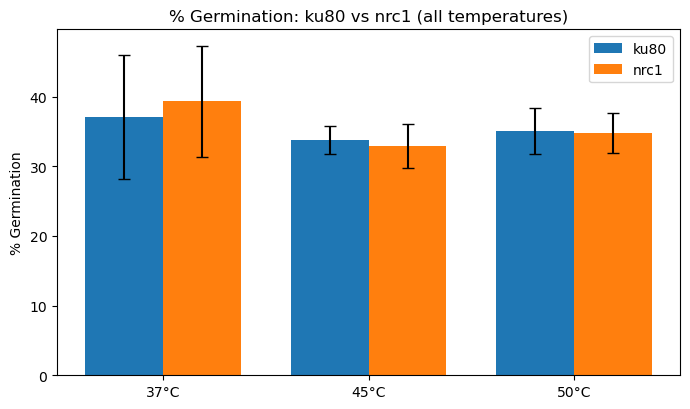


Two-way ANOVA: ku80 vs ptp3
                              sum_sq    df         F    PR(>F)
C(Strain)                 133.994474   1.0  4.777396  0.046322
C(Temperature)              9.318712   2.0  0.166123  0.848587
C(Strain):C(Temperature)   17.069868   2.0  0.304302  0.742395
Residual                  392.666370  14.0       NaN       NaN


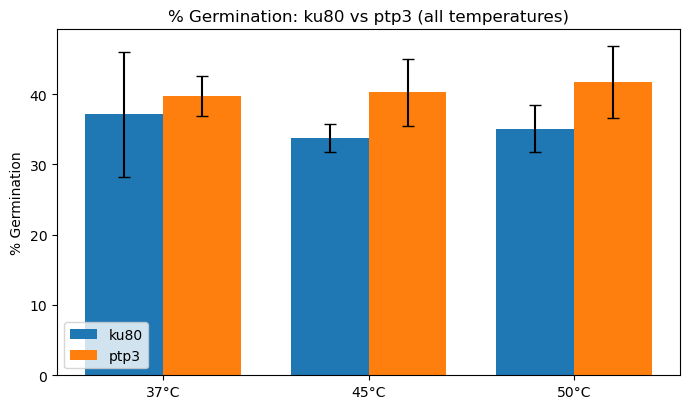


Two-way ANOVA: ku80 vs syg1
                              sum_sq    df         F    PR(>F)
C(Strain)                  13.204815   1.0  0.494428  0.493487
C(Temperature)             28.312293   2.0  0.530049  0.599932
C(Strain):C(Temperature)   11.018909   2.0  0.206291  0.816026
Residual                  373.901495  14.0       NaN       NaN


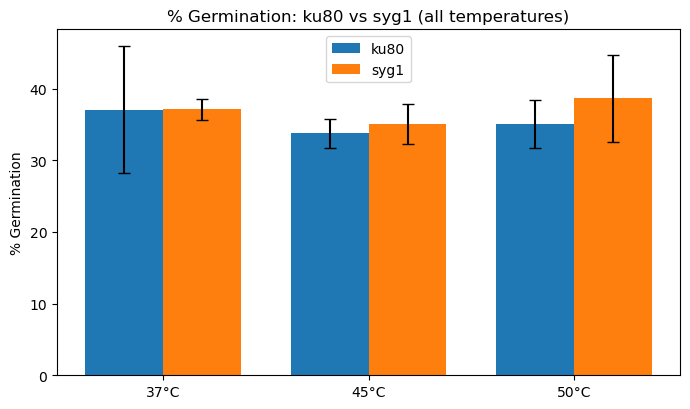


Two-way ANOVA: ku80 vs zip
                              sum_sq    df         F    PR(>F)
C(Strain)                  11.360160   1.0  0.518885  0.481710
C(Temperature)             11.982417   2.0  0.273654  0.764084
C(Strain):C(Temperature)   44.518540   2.0  1.016712  0.384003
Residual                  350.294275  16.0       NaN       NaN


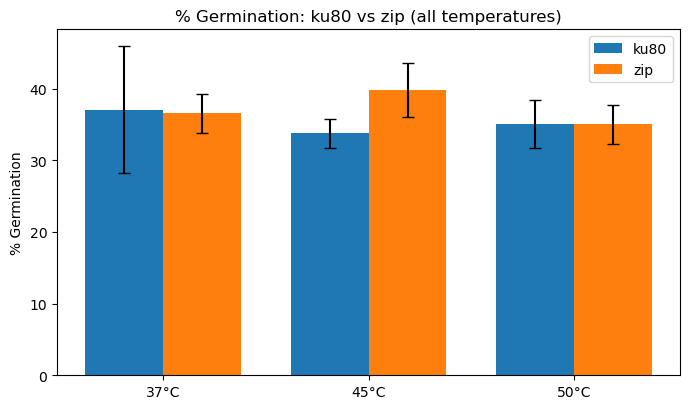

In [6]:
# === Ku80 vs Each Strain: grouped bars + 2-way ANOVA + corrected post-hoc ===
# Expects columns: file, temperature, percent_germinated
# For each strain X != ku80:
#   1) Run two-way ANOVA: percent_germinated ~ C(Strain) * C(Temperature)
#   2) Within each temperature (37/45/50), run Welch's t-test (ku80 vs X);
#      apply Holm correction across the 3 temps; annotate stars only if significant.
# Notes:
#   - Error bars: set ERROR_BARS = "sd" or "sem" or None
#   - Prints the ANOVA table for each ku80 vs X comparison
#   - Set SAVE=True to write PNGs (kept False per your request)

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

# ------------------------- CONFIG --------------------------------------------
CSV_PATH = Path("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/germination_measurements_all_temp_perfile.csv")
KU80_LABEL = "ku80"               # case-insensitive match
TEMPS = [37, 45, 50]              # order on x-axis
GERM_COL = "percent_germinated"   # response variable
ERROR_BARS = "sd"                 # "sd", "sem", or None
ALPHA = 0.05                      # significance threshold AFTER Holm correction
SAVE = False                      # True => save PNGs
OUT_DIR = Path("/mnt/data/germination_grouped_plots")
# -----------------------------------------------------------------------------

# Load & standardize
df = pd.read_csv(CSV_PATH).rename(columns={"file": "Strain", "temperature": "Temperature"})
df["Strain"] = df["Strain"].astype(str).str.strip()
df["strain_lower"] = df["Strain"].str.lower().str.strip()
df["Temperature"] = pd.to_numeric(df["Temperature"], errors="coerce")

def summarize(series: pd.Series):
    vals = series.dropna()
    n = vals.size
    mean = float(vals.mean()) if n else np.nan
    sd = float(vals.std(ddof=1)) if n > 1 else 0.0
    sem = (sd / np.sqrt(n)) if n > 0 else np.nan
    return mean, n, sd, sem

def pick_err(sd, sem):
    if ERROR_BARS == "sd":
        return sd
    if ERROR_BARS == "sem":
        return sem
    return None

def stars(p):
    if p is None or np.isnan(p):
        return None
    if p < 1e-4: return "****"
    if p < 1e-3: return "***"
    if p < 1e-2: return "**"
    if p < 5e-2: return "*"
    return None

def two_way_anova(sub_df: pd.DataFrame):
    # Factors as categories
    d = sub_df.copy()
    d["Strain"] = d["Strain"].astype(str)
    d["Temperature"] = d["Temperature"].astype(int)
    model = ols(f"{GERM_COL} ~ C(Strain) * C(Temperature)", data=d).fit()
    return sm.stats.anova_lm(model, typ=2)

def per_temp_holm_posthoc(sub_df: pd.DataFrame, temps=TEMPS):
    """
    For each temperature, Welch t-test (ku80 vs other). Then Holm-correct across temps.
    Returns dict: {temp: (p_raw, p_corr)} (None if a comparison can't be computed).
    """
    out = {}
    pvals = []
    temp_keys = []
    other_label = [s for s in sub_df["Strain"].unique() if s.lower() != KU80_LABEL.lower()]
    other_label = other_label[0] if other_label else None

    for t in temps:
        a = sub_df[(sub_df["strain_lower"] == KU80_LABEL.lower()) & (sub_df["Temperature"] == t)][GERM_COL].dropna()
        b = sub_df[(sub_df["strain_lower"] != KU80_LABEL.lower()) & (sub_df["Temperature"] == t)][GERM_COL].dropna()
        if a.size >= 1 and b.size >= 1 and (a.var(ddof=1) > 0 or b.var(ddof=1) > 0):
            stat, p = ttest_ind(a, b, equal_var=False, nan_policy="omit")
            pvals.append(p)
            temp_keys.append(t)
        else:
            out[t] = (None, None)

    # Holm correction across the temps we actually tested
    if pvals:
        reject, p_corr, _, _ = multipletests(pvals, alpha=ALPHA, method="holm")
        for t, p_raw, pc in zip(temp_keys, pvals, p_corr):
            out[t] = (p_raw, pc)
    # Ensure all temps present
    for t in temps:
        out.setdefault(t, (None, None))
    return out

def plot_pair_grouped_with_sig(df_all: pd.DataFrame, other_strain_lower: str):
    sub = df_all[df_all["strain_lower"].isin([KU80_LABEL.lower(), other_strain_lower])].copy()
    if sub.empty:
        return

    # 1) Two-way ANOVA
    anova_tbl = two_way_anova(sub)
    other_pretty = sub.loc[sub["strain_lower"] == other_strain_lower, "Strain"].iloc[0]
    print("\n" + "="*72)
    print(f"Two-way ANOVA: ku80 vs {other_pretty}")
    print(anova_tbl)

    # 2) Post-hoc per temperature with Holm correction
    pvals_by_temp = per_temp_holm_posthoc(sub, TEMPS)  # {temp: (p_raw, p_corr)}

    # 3) Prepare bar data (means + error bars)
    ku_means, ku_errs, other_means, other_errs = [], [], [], []
    ymax_est = 0.0
    for t in TEMPS:
        k = sub[(sub["strain_lower"] == KU80_LABEL.lower()) & (sub["Temperature"] == t)][GERM_COL]
        o = sub[(sub["strain_lower"] == other_strain_lower) & (sub["Temperature"] == t)][GERM_COL]
        km, kn, ksd, ksem = summarize(k)
        om, on, osd, osem = summarize(o)
        ku_means.append(km)
        other_means.append(om)
        ku_errs.append(pick_err(ksd, ksem))
        other_errs.append(pick_err(osd, osem))
        ymax_est = max(ymax_est,
                       (km if not np.isnan(km) else 0) + (ku_errs[-1] or 0),
                       (om if not np.isnan(om) else 0) + (other_errs[-1] or 0))

    # 4) Plot
    x = np.arange(len(TEMPS))
    width = 0.38
    fig = plt.figure(figsize=(7, 4.2))
    plt.bar(x - width/2, ku_means, width,
            yerr=ku_errs if ERROR_BARS else None, capsize=4 if ERROR_BARS else 0,
            label="ku80")
    plt.bar(x + width/2, other_means, width,
            yerr=other_errs if ERROR_BARS else None, capsize=4 if ERROR_BARS else 0,
            label=other_pretty)

    plt.xticks(x, [f"{int(t)}°C" for t in TEMPS])
    plt.ylabel("% Germination")
    plt.title(f"% Germination: ku80 vs {other_pretty} (all temperatures)")
    plt.legend()

    # 5) Annotate only if significant after Holm correction
    y_offset = 0.03 * (ymax_est if ymax_est > 0 else 1.0) + 0.5
    for i, t in enumerate(TEMPS):
        p_raw, p_corr = pvals_by_temp.get(t, (None, None))
        mark = stars(p_corr)
        if mark:
            y_i = max(
                (ku_means[i] if not np.isnan(ku_means[i]) else 0) + (ku_errs[i] if ERROR_BARS and ku_errs[i] is not None else 0),
                (other_means[i] if not np.isnan(other_means[i]) else 0) + (other_errs[i] if ERROR_BARS and other_errs[i] is not None else 0)
            ) + y_offset
            x_center = (x[i] - width/2 + x[i] + width/2) / 2
            plt.text(x_center, y_i, mark, ha="center", va="bottom", fontsize=12)

    plt.tight_layout()
    if SAVE:
        OUT_DIR.mkdir(parents=True, exist_ok=True)
        safename = f"ku80_vs_{other_pretty}_grouped_anova_holm.png".replace(" ", "_")
        plt.savefig(OUT_DIR / safename, dpi=150, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

# ---------- Run: one figure + ANOVA printout per non-ku80 strain -------------
other_strains = [s for s in sorted(df["strain_lower"].unique()) if s != KU80_LABEL.lower()]
for s in other_strains:
    plot_pair_grouped_with_sig(df, s)


# for heatmap


=== Two-way ANOVA summaries (ku80 vs each strain) ===
ku80 vs mfs: Strain p=0.896, Temp p=0.877, Interaction p=0.397
ku80 vs nrc1: Strain p=0.816, Temp p=0.271, Interaction p=0.863
ku80 vs ptp3: Strain p=0.0463, Temp p=0.849, Interaction p=0.742
ku80 vs syg1: Strain p=0.493, Temp p=0.6, Interaction p=0.816
ku80 vs zip: Strain p=0.482, Temp p=0.764, Interaction p=0.384


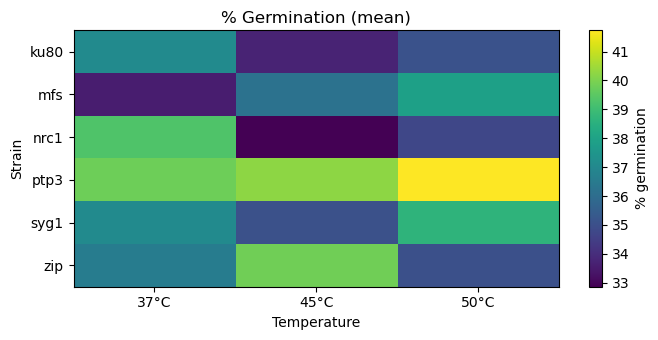

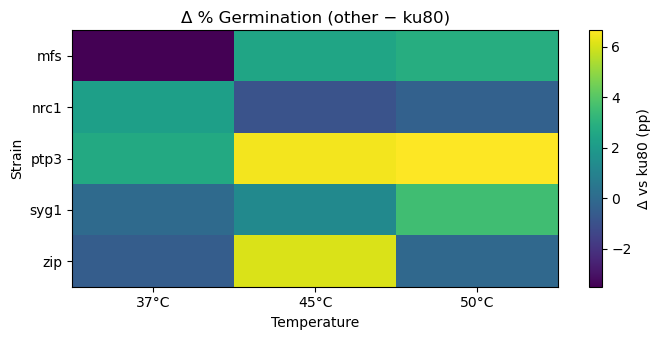

In [1]:
# === Germination Heatmaps: Means + Δ vs ku80 with significance overlays ======
# Input columns expected: file, temperature, percent_germinated
# Outputs:
#   1) Heatmap of mean % germination (rows=strains, columns=37/45/50°C)
#   2) Heatmap of Δ vs ku80 (other - ku80) with Holm-corrected Welch t-test stars
# Also prints per-pair (ku80 vs strain) two-way ANOVA p-values.

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

# ------------------------- CONFIG --------------------------------------------
CSV_PATH = Path("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/germination_measurements_all_temp_perfile.csv")
GERM_COL = "percent_germinated"
TEMPS = [37, 45, 50]          # columns / order on x-axis
KU80 = "ku80"                  # reference strain name (case-insensitive)
ALPHA = 0.05                   # significance threshold for Holm-corrected tests
SAVE = False                   # set True to save PNGs
OUT_DIR = Path("/mnt/data/germination_heatmaps")
# -----------------------------------------------------------------------------

# ---- Load & standardize ----
df = pd.read_csv(CSV_PATH).rename(columns={"file": "Strain", "temperature": "Temperature"})
df["Strain"] = df["Strain"].astype(str).str.strip()
df["strain_lower"] = df["Strain"].str.lower().str.strip()
df["Temperature"] = pd.to_numeric(df["Temperature"], errors="coerce")

# ---- Compute means table (Strain × Temperature) ----
means_long = (
    df.dropna(subset=["Temperature"])
      .groupby(["Strain", "Temperature"])[GERM_COL]
      .mean()
      .reset_index()
)

# Ensure all requested temps present as columns (fill with NaN if missing)
all_strains = sorted(means_long["Strain"].unique().tolist(), key=str.lower)
means = (
    means_long.pivot(index="Strain", columns="Temperature", values=GERM_COL)
              .reindex(index=all_strains, columns=TEMPS)
)

# Put ku80 first if present
if any(means.index.str.lower() == KU80.lower()):
    idx = means.index.tolist()
    idx_sorted = [s for s in idx if s.lower() == KU80.lower()] + [s for s in idx if s.lower() != KU80.lower()]
    means = means.reindex(idx_sorted)

# ---- Δ vs ku80 (other - ku80) ----
if any(means.index.str.lower() == KU80.lower()):
    # vector of ku80 per temperature
    ku_row = means.loc[means.index.str.lower() == KU80.lower()].iloc[0]
    delta_rows = []
    delta_index = []
    for s in means.index:
        if s.lower() == KU80.lower():
            continue
        delta_rows.append(means.loc[s] - ku_row)
        delta_index.append(s)
    delta = pd.DataFrame(delta_rows, index=delta_index, columns=means.columns)
else:
    # If ku80 not found, delta cannot be computed
    delta = pd.DataFrame(index=[s for s in means.index if s.lower() != KU80.lower()], columns=means.columns, dtype=float)

# ---- Per-temperature Welch t-tests (ku80 vs each strain), Holm corrected ----
def holm_per_pair(sub_df: pd.DataFrame, other_lower: str):
    """Return dict {temp: (p_raw, p_corr)} for ku80 vs other at each temp."""
    out = {}
    pvals, keys = [], []
    for t in TEMPS:
        a = sub_df[(sub_df["strain_lower"] == KU80.lower()) & (sub_df["Temperature"] == t)][GERM_COL].dropna()
        b = sub_df[(sub_df["strain_lower"] == other_lower) & (sub_df["Temperature"] == t)][GERM_COL].dropna()
        if a.size >= 1 and b.size >= 1 and (a.var(ddof=1) > 0 or b.var(ddof=1) > 0):
            _, p = ttest_ind(a, b, equal_var=False, nan_policy="omit")
            pvals.append(p); keys.append(t)
        else:
            out[t] = (None, None)
    if pvals:
        _, p_corr, _, _ = multipletests(pvals, alpha=ALPHA, method="holm")
        for t, p_raw, pc in zip(keys, pvals, p_corr):
            out[t] = (p_raw, pc)
    for t in TEMPS:
        out.setdefault(t, (None, None))
    return out

# Build a matrix of stars (same shape as delta) to overlay
star_map = pd.DataFrame(index=delta.index, columns=delta.columns, dtype=object)
for s in delta.index:
    p_dict = holm_per_pair(df[df["strain_lower"].isin([KU80.lower(), s.lower()])], s.lower())
    for t in TEMPS:
        _, p_corr = p_dict[t]
        if p_corr is not None and p_corr < ALPHA:
            # Use standard star thresholds
            if p_corr < 1e-4: mark = "****"
            elif p_corr < 1e-3: mark = "***"
            elif p_corr < 1e-2: mark = "**"
            else: mark = "*"
        else:
            mark = ""
        star_map.loc[s, t] = mark

# ---- Two-way ANOVA per pair: print concise summary ----
def two_way_anova_summary(sub_df: pd.DataFrame):
    d = sub_df.copy()
    d["Strain"] = d["Strain"].astype(str)
    d["Temperature"] = d["Temperature"].astype(int)
    model = ols(f"{GERM_COL} ~ C(Strain) * C(Temperature)", data=d).fit()
    tbl = sm.stats.anova_lm(model, typ=2)
    # Pull p-values safely
    def getp(name):
        try:
            return float(tbl.loc[name, "PR(>F)"])
        except Exception:
            return np.nan
    return getp("C(Strain)"), getp("C(Temperature)"), getp("C(Strain):C(Temperature)")

print("\n=== Two-way ANOVA summaries (ku80 vs each strain) ===")
for s in [r for r in means.index if r.lower() != KU80.lower()]:
    sub = df[df["strain_lower"].isin([KU80.lower(), s.lower()])]
    p_strain, p_temp, p_int = two_way_anova_summary(sub)
    print(f"{KU80} vs {s}: Strain p={p_strain:.3g}, Temp p={p_temp:.3g}, Interaction p={p_int:.3g}")

# ---- Plot: Heatmap of mean % germination (all strains × temps) ----
fig1, ax1 = plt.subplots(figsize=(7, max(3.5, 0.35*len(means))))
im1 = ax1.imshow(means.values, aspect="auto")
ax1.set_xticks(np.arange(len(TEMPS)))
ax1.set_xticklabels([f"{t}°C" for t in TEMPS])
ax1.set_yticks(np.arange(len(means.index)))
ax1.set_yticklabels(means.index)
ax1.set_title("% Germination (mean)")
ax1.set_xlabel("Temperature")
ax1.set_ylabel("Strain")
fig1.colorbar(im1, ax=ax1, label="% germination")
plt.tight_layout()
if SAVE:
    OUT_DIR.mkdir(parents=True, exist_ok=True)
    fig1.savefig(OUT_DIR / "heatmap_means.png", dpi=150, bbox_inches="tight")
plt.show()

# ---- Plot: Heatmap of Δ vs ku80 (other - ku80) with stars ----
if not delta.empty:
    fig2, ax2 = plt.subplots(figsize=(7, max(3.5, 0.35*len(delta))))
    im2 = ax2.imshow(delta.values, aspect="auto")
    ax2.set_xticks(np.arange(len(TEMPS)))
    ax2.set_xticklabels([f"{t}°C" for t in TEMPS])
    ax2.set_yticks(np.arange(len(delta.index)))
    ax2.set_yticklabels(delta.index)
    ax2.set_title("Δ % Germination (other − ku80)")
    ax2.set_xlabel("Temperature")
    ax2.set_ylabel("Strain")

    # overlay significance stars
    for i, s in enumerate(delta.index):
        for j, t in enumerate(TEMPS):
            mark = star_map.loc[s, t]
            if isinstance(mark, str) and len(mark) > 0:
                ax2.text(j, i, mark, ha="center", va="center", fontsize=12)

    fig2.colorbar(im2, ax=ax2, label="Δ vs ku80 (pp)")
    plt.tight_layout()
    if SAVE:
        fig2.savefig(OUT_DIR / "heatmap_delta_vs_ku80.png", dpi=150, bbox_inches="tight")
    plt.show()
else:
    print("Note: ku80 not found — Δ vs ku80 heatmap skipped.")


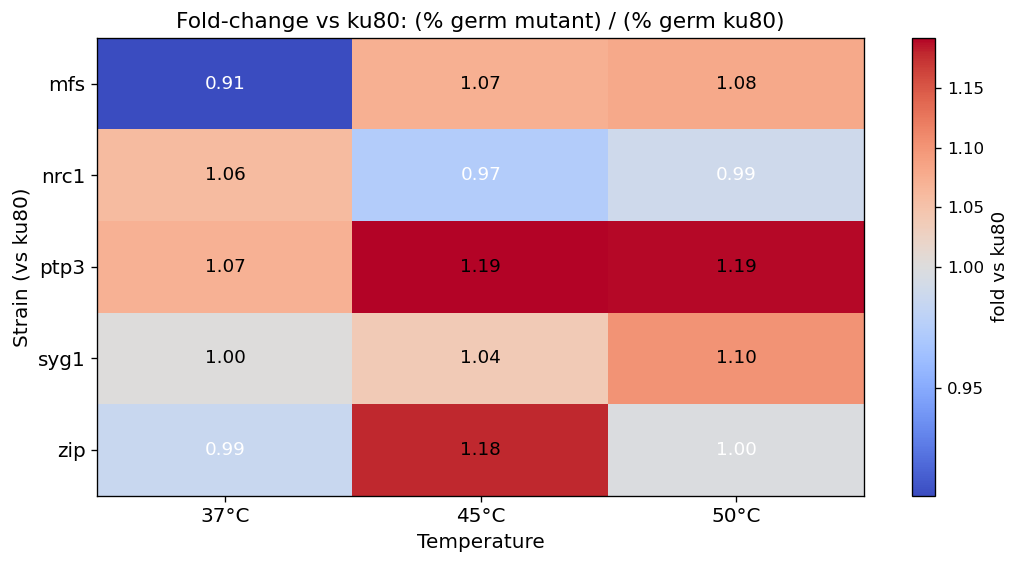

In [1]:
# === Heatmap: (% germ mutant) / (% germ ku80) by temperature =================
# Input CSV columns expected: file, temperature, percent_germinated
# What you get:
#   - Heatmap of fold-change vs ku80 (mutant / ku80) for each temperature
#   - Values printed in each cell (2 decimals)
#   - Optional stars for per-temperature significance (Holm-corrected Welch t-tests)

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# ------------------------- CONFIG --------------------------------------------
CSV_PATH = Path("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/germination_measurements_all_temp_perfile.csv")
GERM_COL = "percent_germinated"
TEMPS = [37, 45, 50]          # x-axis order
KU80 = "ku80"                  # reference strain name (case-insensitive)
ALPHA = 0.05                   # Holm-corrected threshold
SHOW_STARS = True              # set False to hide significance stars
FIGSIZE = (9, 4.8)
DPI = 120
VAL_FMT = "{:.2f}"             # 2 decimal places for ratios
# -----------------------------------------------------------------------------

# ---- Load & standardize ----
df = pd.read_csv(CSV_PATH).rename(columns={"file": "Strain", "temperature": "Temperature"})
df["Strain"] = df["Strain"].astype(str).str.strip()
df["strain_lower"] = df["Strain"].str.lower().str.strip()
df["Temperature"] = pd.to_numeric(df["Temperature"], errors="coerce")

# ---- Mean %germ table (Strain × Temp) ----
means_long = (
    df.dropna(subset=["Temperature"])
      .groupby(["Strain", "Temperature"])[GERM_COL]
      .mean()
      .reset_index()
)

strains = sorted(means_long["Strain"].unique().tolist(), key=str.lower)
means = (
    means_long.pivot(index="Strain", columns="Temperature", values=GERM_COL)
              .reindex(index=strains, columns=TEMPS)
)

# ---- Build ratio table: (mutant / ku80) per temperature ----
if not any(means.index.str.lower() == KU80.lower()):
    raise ValueError("ku80 not found among strains. Check your 'file' (Strain) names.")

ku_row = means.loc[means.index.str.lower() == KU80.lower()].iloc[0]
# Avoid division-by-zero: where ku80 mean is 0, ratio becomes NaN
ku_safe = ku_row.replace(0, np.nan)

ratio_rows = []
ratio_index = []
for s in means.index:
    if s.lower() == KU80.lower():
        continue
    ratio_rows.append(means.loc[s] / ku_safe)
    ratio_index.append(s)

ratio = pd.DataFrame(ratio_rows, index=ratio_index, columns=means.columns)

# ---- Optional per-temperature significance vs ku80 (Holm-corrected Welch t) ----
def holm_vs_ku80(sub_df, other_lower):
    out = {}
    pvals, keys = [], []
    for t in TEMPS:
        a = sub_df[(sub_df["strain_lower"] == KU80.lower()) & (sub_df["Temperature"] == t)][GERM_COL].dropna()
        b = sub_df[(sub_df["strain_lower"] == other_lower) & (sub_df["Temperature"] == t)][GERM_COL].dropna()
        if len(a) >= 1 and len(b) >= 1 and (a.var(ddof=1) > 0 or b.var(ddof=1) > 0):
            _, p = ttest_ind(a, b, equal_var=False, nan_policy="omit")
            pvals.append(p); keys.append(t)
        else:
            out[t] = (None, None)
    if pvals:
        _, p_corr, _, _ = multipletests(pvals, alpha=ALPHA, method="holm")
        for t, p_raw, pc in zip(keys, pvals, p_corr):
            out[t] = (p_raw, pc)
    for t in TEMPS:
        out.setdefault(t, (None, None))
    return out

def star_from_p(p):
    if p is None or np.isnan(p): return ""
    if p < 1e-4: return "****"
    if p < 1e-3: return "***"
    if p < 1e-2: return "**"
    if p < 5e-2: return "*"
    return ""

stars = pd.DataFrame("", index=ratio.index, columns=ratio.columns)
if SHOW_STARS:
    for s in ratio.index:
        sub = df[df["strain_lower"].isin([KU80.lower(), s.lower()])]
        pmap = holm_vs_ku80(sub, s.lower())
        for t in TEMPS:
            _, pc = pmap[t]
            stars.loc[s, t] = star_from_p(pc)

# ---- Helper to write values in cells with auto-contrast text color ----
def annotate_cells(ax, data_2d, fmt=VAL_FMT, stars=None):
    arr = np.array(data_2d, dtype=float)
    im = ax.images[0]
    norm = im.norm
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            val = arr[i, j]
            if np.isnan(val): 
                continue
            # text string: ratio (and star if enabled)
            sfx = stars[i, j] if (stars is not None) else ""
            txt = (fmt.format(val) + sfx) if sfx else fmt.format(val)
            nv = norm(val) if hasattr(norm, "__call__") else 0.5
            color = "white" if nv < 0.5 else "black"
            ax.text(j, i, txt, ha="center", va="center", fontsize=11, color=color)

# ---- Plot: heatmap of fold-change vs ku80 ----
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Center the diverging scale at 1.0 (no change)
vmin = np.nanmin(ratio.values)
vmax = np.nanmax(ratio.values)
# widen bounds a bit so 1.0 is well centered even if data are tight
pad = 0.05
vmin = min(vmin, 1.0 - pad)
vmax = max(vmax, 1.0 + pad)
norm = TwoSlopeNorm(vmin=vmin, vcenter=1.0, vmax=vmax)

im = ax.imshow(ratio.values, aspect="auto", norm=norm, cmap="coolwarm")
ax.set_xticks(np.arange(len(TEMPS))); ax.set_xticklabels([f"{t}°C" for t in TEMPS], fontsize=12)
ax.set_yticks(np.arange(len(ratio.index))); ax.set_yticklabels(ratio.index, fontsize=12)
ax.set_xlabel("Temperature", fontsize=12)
ax.set_ylabel("Strain (vs ku80)", fontsize=12)
ax.set_title("Fold-change vs ku80: (% germ mutant) / (% germ ku80)", fontsize=13)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label("fold vs ku80", fontsize=11)

annotate_cells(ax, ratio.values, fmt=VAL_FMT, stars=stars.values if SHOW_STARS else None)

plt.tight_layout()
plt.show()


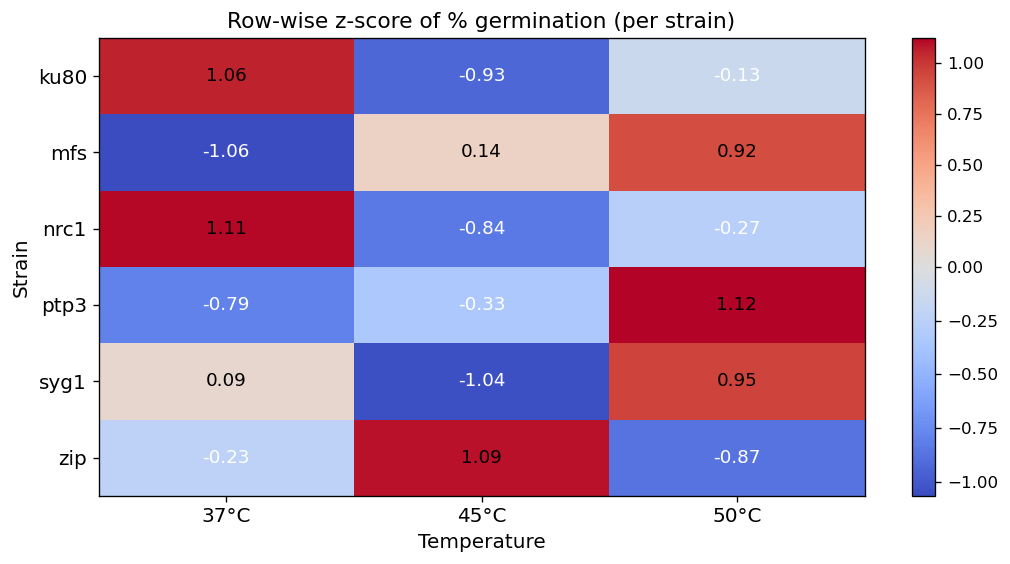

In [2]:
# === Heatmaps: fold-vs-ku80 OR row z-score OR row mean-normalized ============
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# ---------------- CONFIG ----------------
CSV_PATH = Path("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/germination_measurements_all_temp_perfile.csv")
GERM_COL = "percent_germinated"
TEMPS = [37, 45, 50]
KU80 = "ku80"
MODE = "row_zscore"        # <- choose: "fold_vs_ku80" | "row_zscore" | "row_mean_norm"
VAL_FMT = "{:.2f}"
FIGSIZE = (9, 4.8)
DPI = 120
# ----------------------------------------

# Load & pivot to means table (Strain x Temp)
df = pd.read_csv(CSV_PATH).rename(columns={"file":"Strain", "temperature":"Temperature"})
df["Strain"] = df["Strain"].astype(str).str.strip()
df["Temperature"] = pd.to_numeric(df["Temperature"], errors="coerce")

means_long = (
    df.dropna(subset=["Temperature"])
      .groupby(["Strain","Temperature"])[GERM_COL].mean()
      .reset_index()
)
strains = sorted(means_long["Strain"].unique().tolist(), key=str.lower)
means = (
    means_long.pivot(index="Strain", columns="Temperature", values=GERM_COL)
              .reindex(index=strains, columns=TEMPS)
)

def plot_heatmap(data, title, center=None, cmap="coolwarm"):
    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
    if center is None:
        im = ax.imshow(data.values, aspect="auto", cmap=cmap)
    else:
        vmin = np.nanmin(data.values); vmax = np.nanmax(data.values)
        # add a small pad so the center is visually balanced
        pad = 1e-6
        norm = TwoSlopeNorm(vmin=min(vmin, center - 0.05) - pad, vcenter=center, vmax=max(vmax, center + 0.05) + pad)
        im = ax.imshow(data.values, aspect="auto", cmap=cmap, norm=norm)
    ax.set_xticks(np.arange(len(TEMPS))); ax.set_xticklabels([f"{t}°C" for t in TEMPS], fontsize=12)
    ax.set_yticks(np.arange(len(data.index))); ax.set_yticklabels(data.index, fontsize=12)
    ax.set_xlabel("Temperature", fontsize=12); ax.set_ylabel("Strain", fontsize=12)
    ax.set_title(title, fontsize=13)
    cbar = fig.colorbar(im, ax=ax)

    # annotate values inside cells with auto-contrast text color
    norm = im.norm
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data.iat[i, j]
            if pd.isna(val): 
                continue
            nv = norm(val) if callable(norm) else 0.5
            color = "white" if nv < 0.5 else "black"
            ax.text(j, i, VAL_FMT.format(val), ha="center", va="center", fontsize=11, color=color)

    plt.tight_layout()
    plt.show()

if MODE == "fold_vs_ku80":
    # mutant / ku80 (per temperature)
    if not any(means.index.str.lower() == KU80.lower()):
        raise ValueError("ku80 not found among strains.")
    ku = means.loc[means.index.str.lower() == KU80.lower()].iloc[0].replace(0, np.nan)
    ratio = means.drop(index=[s for s in means.index if s.lower() == KU80.lower()]) / ku
    plot_heatmap(ratio, "Fold-change vs ku80: (% germ mutant) / (% germ ku80)", center=1.0)

elif MODE == "row_zscore":
    # z-score per row (strain) across temperatures: (x - mean_row) / sd_row
    z = means.copy()
    for s in z.index:
        row = z.loc[s].astype(float)
        m = np.nanmean(row.values)
        sd = np.nanstd(row.values, ddof=1)
        z.loc[s] = (row - m) / sd if sd not in (0, np.nan) else 0.0
    plot_heatmap(z, "Row-wise z-score of % germination (per strain)", center=0.0)

elif MODE == "row_mean_norm":
    # divide each row by its own row mean: x / mean_row (1.0 = row average)
    row_means = means.mean(axis=1)
    norm_row = means.div(row_means, axis=0)
    plot_heatmap(norm_row, "Row-wise mean normalization of % germination (per strain)", center=1.0)

else:
    raise ValueError("Unknown MODE.")


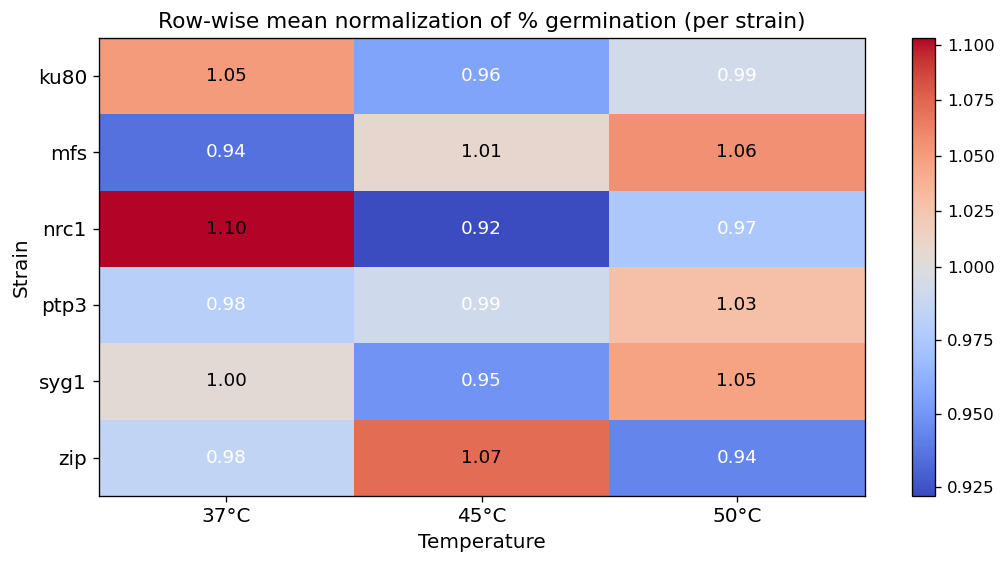

In [3]:
# === Heatmaps: fold-vs-ku80 OR row z-score OR row mean-normalized ============
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

# ---------------- CONFIG ----------------
CSV_PATH = Path("/usr2/people/shollyt22/shollyt22/TnSeq_BarSeq_sequencings/germination_assay_09_09_25/germination_measurements_all_temp_perfile.csv")
GERM_COL = "percent_germinated"
TEMPS = [37, 45, 50]
KU80 = "ku80"
MODE = "row_mean_norm"        # <- choose: "fold_vs_ku80" | "row_zscore" | "row_mean_norm"
VAL_FMT = "{:.2f}"
FIGSIZE = (9, 4.8)
DPI = 120
# ----------------------------------------

# Load & pivot to means table (Strain x Temp)
df = pd.read_csv(CSV_PATH).rename(columns={"file":"Strain", "temperature":"Temperature"})
df["Strain"] = df["Strain"].astype(str).str.strip()
df["Temperature"] = pd.to_numeric(df["Temperature"], errors="coerce")

means_long = (
    df.dropna(subset=["Temperature"])
      .groupby(["Strain","Temperature"])[GERM_COL].mean()
      .reset_index()
)
strains = sorted(means_long["Strain"].unique().tolist(), key=str.lower)
means = (
    means_long.pivot(index="Strain", columns="Temperature", values=GERM_COL)
              .reindex(index=strains, columns=TEMPS)
)

def plot_heatmap(data, title, center=None, cmap="coolwarm"):
    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
    if center is None:
        im = ax.imshow(data.values, aspect="auto", cmap=cmap)
    else:
        vmin = np.nanmin(data.values); vmax = np.nanmax(data.values)
        # add a small pad so the center is visually balanced
        pad = 1e-6
        norm = TwoSlopeNorm(vmin=min(vmin, center - 0.05) - pad, vcenter=center, vmax=max(vmax, center + 0.05) + pad)
        im = ax.imshow(data.values, aspect="auto", cmap=cmap, norm=norm)
    ax.set_xticks(np.arange(len(TEMPS))); ax.set_xticklabels([f"{t}°C" for t in TEMPS], fontsize=12)
    ax.set_yticks(np.arange(len(data.index))); ax.set_yticklabels(data.index, fontsize=12)
    ax.set_xlabel("Temperature", fontsize=12); ax.set_ylabel("Strain", fontsize=12)
    ax.set_title(title, fontsize=13)
    cbar = fig.colorbar(im, ax=ax)

    # annotate values inside cells with auto-contrast text color
    norm = im.norm
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            val = data.iat[i, j]
            if pd.isna(val): 
                continue
            nv = norm(val) if callable(norm) else 0.5
            color = "white" if nv < 0.5 else "black"
            ax.text(j, i, VAL_FMT.format(val), ha="center", va="center", fontsize=11, color=color)

    plt.tight_layout()
    plt.show()

if MODE == "fold_vs_ku80":
    # mutant / ku80 (per temperature)
    if not any(means.index.str.lower() == KU80.lower()):
        raise ValueError("ku80 not found among strains.")
    ku = means.loc[means.index.str.lower() == KU80.lower()].iloc[0].replace(0, np.nan)
    ratio = means.drop(index=[s for s in means.index if s.lower() == KU80.lower()]) / ku
    plot_heatmap(ratio, "Fold-change vs ku80: (% germ mutant) / (% germ ku80)", center=1.0)

elif MODE == "row_zscore":
    # z-score per row (strain) across temperatures: (x - mean_row) / sd_row
    z = means.copy()
    for s in z.index:
        row = z.loc[s].astype(float)
        m = np.nanmean(row.values)
        sd = np.nanstd(row.values, ddof=1)
        z.loc[s] = (row - m) / sd if sd not in (0, np.nan) else 0.0
    plot_heatmap(z, "Row-wise z-score of % germination (per strain)", center=0.0)

elif MODE == "row_mean_norm":
    # divide each row by its own row mean: x / mean_row (1.0 = row average)
    row_means = means.mean(axis=1)
    norm_row = means.div(row_means, axis=0)
    plot_heatmap(norm_row, "Row-wise mean normalization of % germination (per strain)", center=1.0)

else:
    raise ValueError("Unknown MODE.")
